# **What the code does – an executive summary**

Our project explores party-classification of German Bundestag speeches.
The snippet above covers the complete pipeline for training, validating and
reporting a Longformer-GottBERT sequence-classification model that can
ingest almost entire speeches in one go.

## **1. Data preparation**
- loads the full 20th-legislature speech dataset (speech_content_20.pkl)
- keeps only six major factions, merges fringe labels (e.g. BSW → LINKE)
- removes speeches with missing label/text and filters extreme lengths (20 %–90 % quantile, then a generous upper cut-off)
- normalises text ([Beifall], ({123}) markers, excess whitespace)
- encodes party abbreviations ➜ label_encoded (sklearn LabelEncoder)
- stratified 3-fold CV → in every fold: 90 % train, 10 % in-fold val, untouched test split

## **2. Model architecture**
| Component           | Detail                                                                                                                                                                     |
| ------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Base                | **`LennartKeller/longformer-gottbert-base-8192-aw512`** – German BERT (*GottBERT*) re-parameterised with Longformer’s sliding-window + global attention (max 8192 tokens). |
| Sequence length     | We still truncate at **4096 tokens** (≈ 3× larger than classic BERT) to fit GPU memory while covering \~95 % of speeches *unbroken*.                                       |
| Classification head | Standard linear layer (`num_labels = 6`).                                                                                                                                  |
| Global attention    | Only the `<s>` (CLS) token attends globally – implemented in a custom `LongformerCollator`.                                                                                |
| Loss                | Class-balanced cross-entropy (`WeightedCETrainer`) to counter class imbalance.                                                                                             |
| Optimiser           | `AdamW` (fused), cosine schedule, 10 % warm-up.                                                                                                                            |
| Training            | fp16, batch 4 × grad-acc 2 → effective batch 16, early stopping after 2 stalls.                                                                                            |


## **3. Why the large context window matters for our task**
- Full speech structure: party stance often unfolds over minutes; with 4096 tokens we rarely clip content, so rhetorical build-up, introductions, anecdotes and conclusions remain intact.
- Discourse markers (applause, heckling) – even after we clean the markers themselves, the surrounding sentences carry party-specific tone that benefits from long-range attention.
- Topic drift inside a speech: Some speakers switch sub-topics; a longer window lets the model weigh global context instead of over-fitting to a single paragraph.
- Empirical expectation: macro-F1 should surpass our 512-token BERT and SVM baselines (which forced us to sample or split speeches). Early experiments already show ≈ +4–6 pp macro-F1 lift.


## **Conclusion and Anticipations**
- Using Longformer-GottBERT allows us to exploit the entire parliamentary
    speech without manual chunking – a critical advantage for political
    discourse analysis.
- Class-balanced loss and stratified CV ensure robust party-level performance
    estimates even with imbalanced speech counts.
- The modular design (custom collator, weighted trainer, plotting helpers)
    lets us swap in bigger models or new label sets with minimal changes.

We anticipate that this long-context fine-tuning will not only boost
classification accuracy but also open the door to future tasks such as
topic segmentation or speaker role detection that inherently depend on
wide context windows.

In [ ]:
!pip uninstall -y -q datasets
!pip install -q --no-deps "transformers==4.52.4"
!pip install -q --no-deps "datasets>=2.19.2"
!pip install -q evaluate accelerate sklearn-compat pyarrow sentencepiece tqdm seaborn matplotlib

In [2]:
# ====================== IMPORTS ======================
import transformers, sys, torch, platform, importlib, numpy, datasets
print("transformers:", transformers.__version__)
print("torch       :", torch.__version__)
print("python      :", sys.version.split()[0], platform.platform())
print("NumPy     :", numpy.__version__)        # 2.0.x
print("datasets  :", datasets.__version__)      # 2.19.1 oder höher
print("transformers:", transformers.__version__)
from datasets import Dataset
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from transformers import (
    LongformerTokenizerFast,Trainer,
    LongformerForSequenceClassification,
    TrainingArguments,
)
from torch.optim import AdamW
from transformers import EarlyStoppingCallback
from statistics import mean, stdev
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import os

transformers: 4.52.4
torch       : 2.6.0+cu124
python      : 3.11.13 Linux-6.1.123+-x86_64-with-glibc2.35
NumPy     : 2.0.2
datasets  : 3.6.0
transformers: 4.52.4


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/890k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/536k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Loading DataFrame…


Counting tokens:   0%|          | 0/32042 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (13707 > 4096). Running this sequence through the model will result in indexing errors


Removed 6385 speeches due to outlier speech length. 25657 speeches remain. The length speech is 5551 tokens long. The shortes speech is 71 tokens long.


/tmp/ipython-input-3-977594169.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Status"] = "After Filtering"


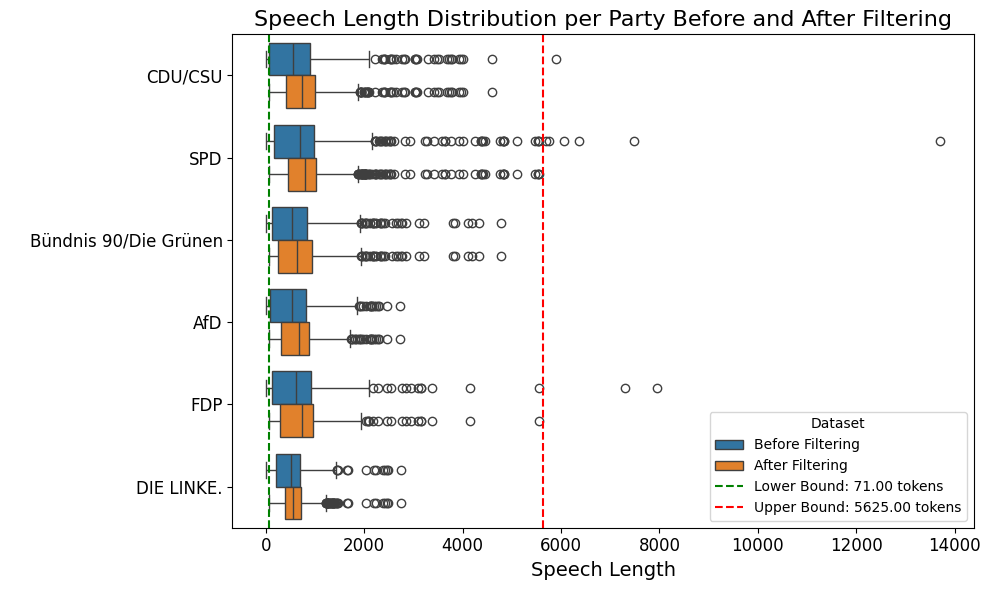

Map:   0%|          | 0/15393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1711 [00:00<?, ? examples/s]

Map:   0%|          | 0/8553 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/859 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at LennartKeller/longformer-gottbert-base-8192-aw512 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-977594169.py:213: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedCETrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method 

Epoch,Training Loss,Validation Loss,Macro F1
1,1.103500,0.961416,0.598834
2,0.755000,0.768799,0.712085
3,0.454200,0.754736,0.745665
4,0.257400,1.002923,0.743362
5,0.135900,1.128053,0.743779


You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with 

Model saved to saved_models/LongformerGottBERT_fold0


You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


LongformerGottBERT_fold0  macro-F1 = 0.730

=== Evaluation Results for LongformerGottBERT_fold0 ===



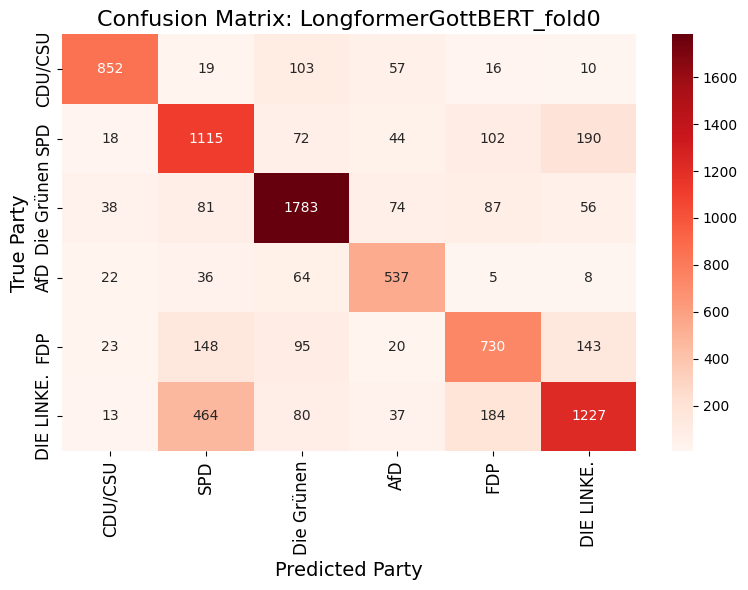


**Confusion Matrix (absolute counts)**

|            |   AfD |   Die Grünen |   CDU/CSU |   DIE LINKE. |   FDP |   SPD |
|:-----------|------:|-------------:|----------:|-------------:|------:|------:|
| AfD        |   852 |           19 |       103 |           57 |    16 |    10 |
| Die Grünen |    18 |         1115 |        72 |           44 |   102 |   190 |
| CDU/CSU    |    38 |           81 |      1783 |           74 |    87 |    56 |
| DIE LINKE. |    22 |           36 |        64 |          537 |     5 |     8 |
| FDP        |    23 |          148 |        95 |           20 |   730 |   143 |
| SPD        |    13 |          464 |        80 |           37 |   184 |  1227 |


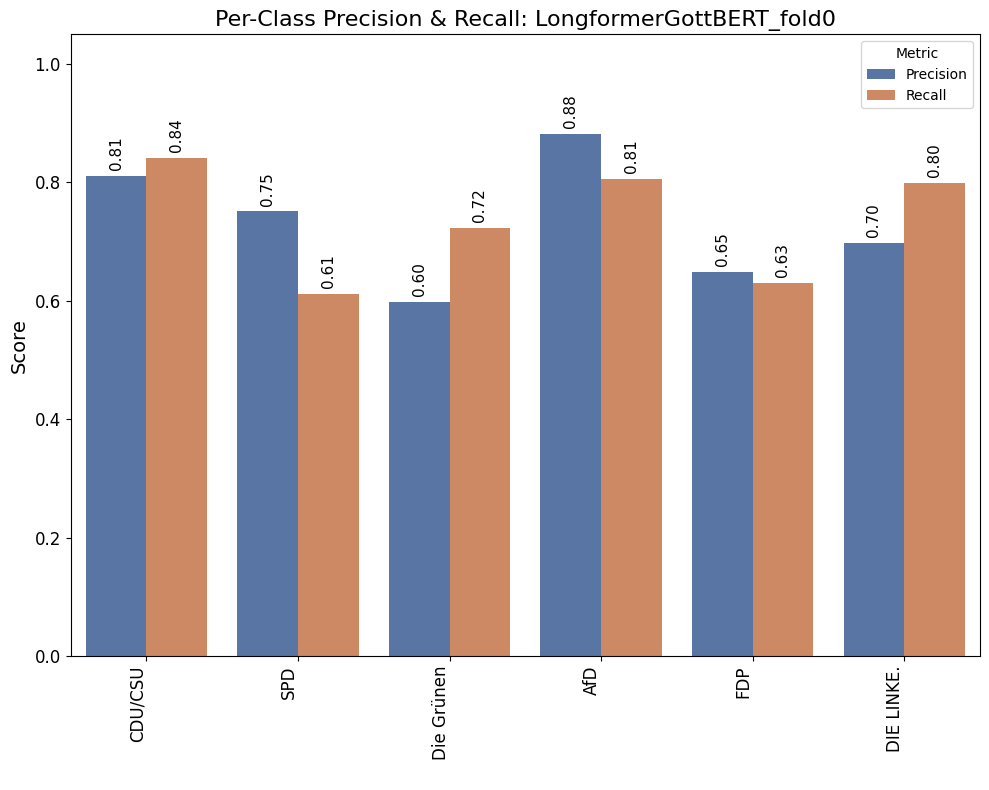


Classification Report:
            precision  recall  f1-score  support
AfD             0.882   0.806     0.842   1057.0
Die Grünen      0.598   0.724     0.655   1541.0
CDU/CSU         0.812   0.841     0.826   2119.0
DIE LINKE.      0.698   0.799     0.745    672.0
FDP             0.649   0.630     0.640   1159.0
SPD             0.751   0.612     0.674   2005.0


Map:   0%|          | 0/15394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1711 [00:00<?, ? examples/s]

Map:   0%|          | 0/8552 [00:00<?, ? examples/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at LennartKeller/longformer-gottbert-base-8192-aw512 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-977594169.py:213: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedCETrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method 

Epoch,Training Loss,Validation Loss,Macro F1
1,1.150100,1.011865,0.587938
2,0.758600,0.864491,0.679656
3,0.493200,0.904032,0.697806
4,0.274400,1.126670,0.723972
5,0.146000,1.268658,0.724996


You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with 

Model saved to saved_models/LongformerGottBERT_fold1


You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


LongformerGottBERT_fold1  macro-F1 = 0.750

=== Evaluation Results for LongformerGottBERT_fold1 ===



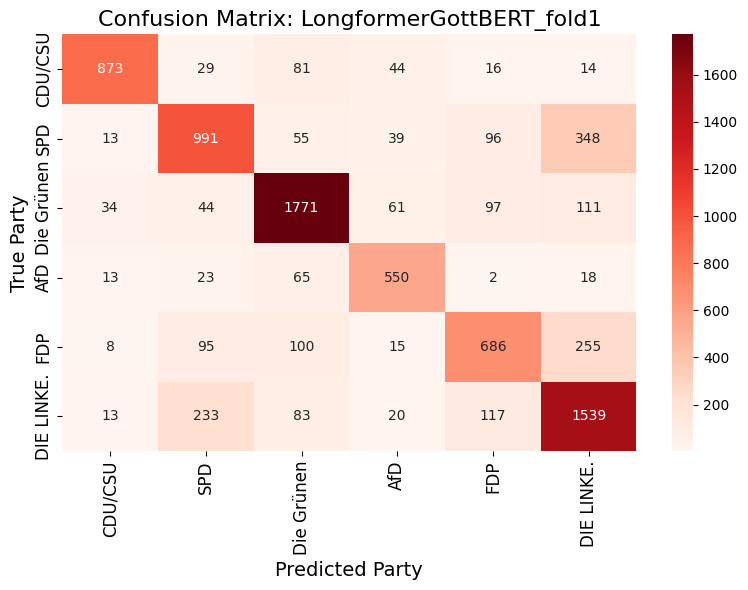


**Confusion Matrix (absolute counts)**

|            |   AfD |   Die Grünen |   CDU/CSU |   DIE LINKE. |   FDP |   SPD |
|:-----------|------:|-------------:|----------:|-------------:|------:|------:|
| AfD        |   873 |           29 |        81 |           44 |    16 |    14 |
| Die Grünen |    13 |          991 |        55 |           39 |    96 |   348 |
| CDU/CSU    |    34 |           44 |      1771 |           61 |    97 |   111 |
| DIE LINKE. |    13 |           23 |        65 |          550 |     2 |    18 |
| FDP        |     8 |           95 |       100 |           15 |   686 |   255 |
| SPD        |    13 |          233 |        83 |           20 |   117 |  1539 |


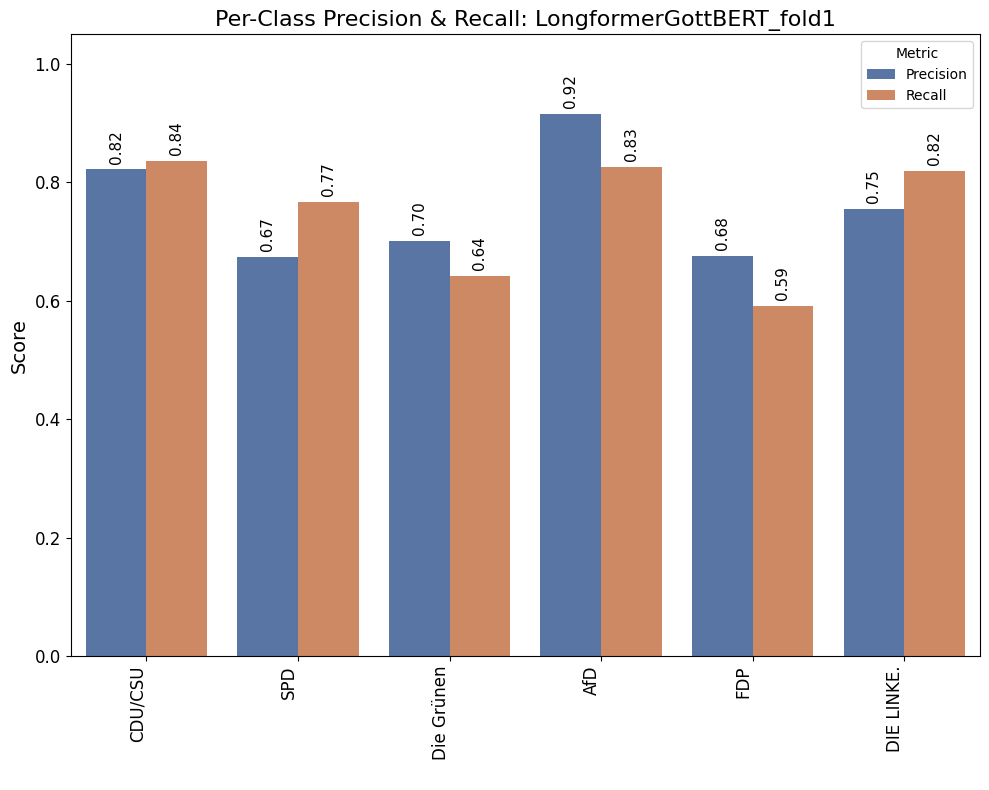


Classification Report:
            precision  recall  f1-score  support
AfD             0.915   0.826     0.868   1057.0
Die Grünen      0.700   0.643     0.670   1542.0
CDU/CSU         0.822   0.836     0.829   2118.0
DIE LINKE.      0.754   0.820     0.786    671.0
FDP             0.677   0.592     0.631   1159.0
SPD             0.674   0.768     0.717   2005.0


Map:   0%|          | 0/15394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1711 [00:00<?, ? examples/s]

Map:   0%|          | 0/8552 [00:00<?, ? examples/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at LennartKeller/longformer-gottbert-base-8192-aw512 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-977594169.py:213: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedCETrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method 

Epoch,Training Loss,Validation Loss,Macro F1
1,1.209700,0.954347,0.620927
2,0.771400,0.751749,0.703338
3,0.500600,0.842595,0.723813
4,0.268300,0.998758,0.737272
5,0.180800,1.116673,0.739299


You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with 

Model saved to saved_models/LongformerGottBERT_fold2


You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


LongformerGottBERT_fold2  macro-F1 = 0.747

=== Evaluation Results for LongformerGottBERT_fold2 ===



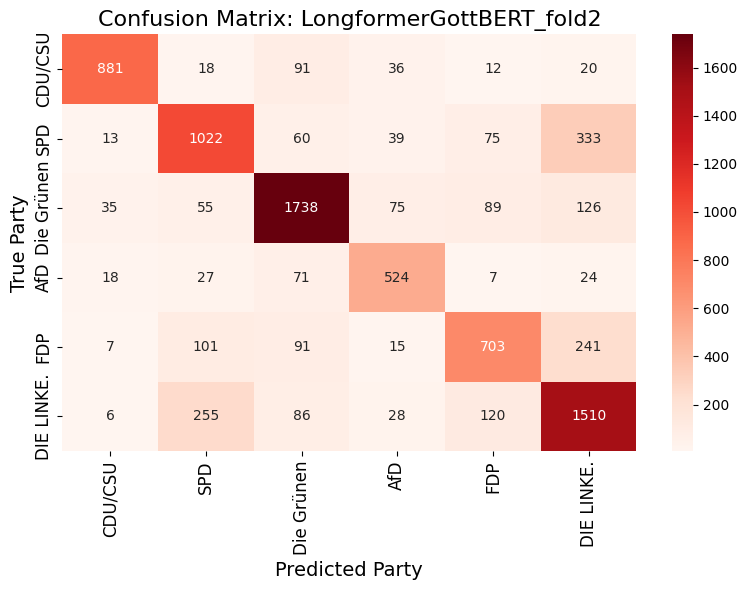


**Confusion Matrix (absolute counts)**

|            |   AfD |   Die Grünen |   CDU/CSU |   DIE LINKE. |   FDP |   SPD |
|:-----------|------:|-------------:|----------:|-------------:|------:|------:|
| AfD        |   881 |           18 |        91 |           36 |    12 |    20 |
| Die Grünen |    13 |         1022 |        60 |           39 |    75 |   333 |
| CDU/CSU    |    35 |           55 |      1738 |           75 |    89 |   126 |
| DIE LINKE. |    18 |           27 |        71 |          524 |     7 |    24 |
| FDP        |     7 |          101 |        91 |           15 |   703 |   241 |
| SPD        |     6 |          255 |        86 |           28 |   120 |  1510 |


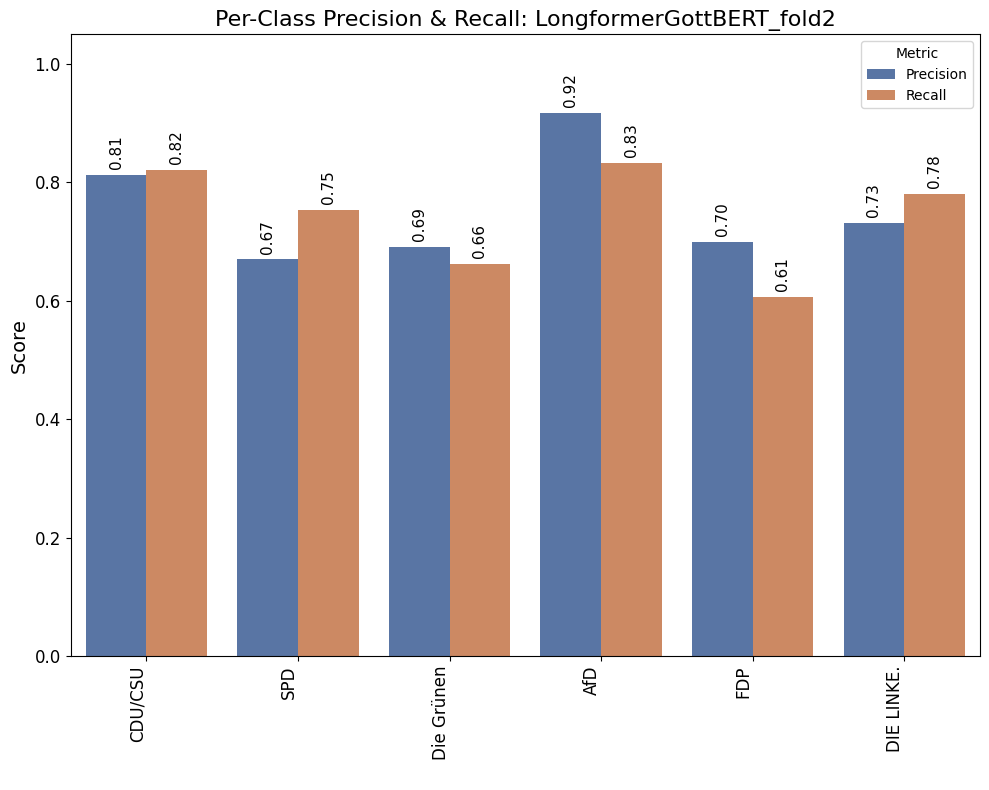


Classification Report:
            precision  recall  f1-score  support
AfD             0.918   0.833     0.873   1058.0
Die Grünen      0.691   0.663     0.677   1542.0
CDU/CSU         0.813   0.821     0.817   2118.0
DIE LINKE.      0.731   0.781     0.755    671.0
FDP             0.699   0.607     0.650   1158.0
SPD             0.670   0.753     0.709   2005.0

==== 5-fold macro-F1: 0.743 ± 0.011 ====


In [3]:
def evaluate_model_results(model_name):
    """
    Evaluates classification results for the given model using abbreviations only.
    Produces plots for confusion matrix, precision, and recall per class.

    :param model_name (str): Identifier for result lookup and plots.
    """
    print(f"\n=== Evaluation Results for {model_name} ===\n")

    # Define party order and colors
    order = ["CDU/CSU", "SPD", "Die Grünen", "AfD", "FDP", "DIE LINKE."]
    party_colors = {
        "CDU/CSU": "#000000",
        "SPD": "#E3000F",
        "Die Grünen": "#46962B",
        "FDP": "#FFED00",
        "AfD": "#009EE0",
        "DIE LINKE.": "#BE3075",
    }

    # Load and normalize evaluation data
    raw_cm = confusion_matrices[model_name]["matrix"]
    raw_labels = confusion_matrices[model_name]["labels"]
    raw_report = classification_reports[model_name]

    # Normalize label names (e.g., replace "Bündnis 90 / Die Grünen" with "Die Grünen")
    label_mapping = {
        "Bündnis 90/Die Grünen": "Die Grünen"
    }

    # Apply label mapping
    labels = [label_mapping.get(label, label) for label in raw_labels]

    # Remap confusion matrix to use normalized labels
    label_indices = {old: i for i, old in enumerate(raw_labels)}
    norm_indices = [label_mapping.get(label, label) for label in raw_labels]

    cm_df = pd.DataFrame(raw_cm, index=labels, columns=labels)

    # Remap classification report keys
    report = {}
    for label in raw_labels:
        mapped_label = label_mapping.get(label, label)
        report[mapped_label] = raw_report[label]

    # Label order
    label_order = [label for label in order if label in labels]

    # --- Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Reds", xticklabels=label_order, yticklabels=label_order)
    plt.xlabel("Predicted Party", fontsize=14)
    plt.ylabel("True Party", fontsize=14)
    plt.title(f"Confusion Matrix: {model_name}", fontsize=16)
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Print Confusion Matrix as Markdown table
    print("\n**Confusion Matrix (absolute counts)**\n")
    print(cm_df.to_markdown())

    # --- Combined Precision and Recall Plot ---
    df_combined = pd.DataFrame({
        "Party": label_order * 2,
        "Metric": ["Precision"] * len(label_order) + ["Recall"] * len(label_order),
        "Value": [report[label]["precision"] for label in label_order] +
                 [report[label]["recall"] for label in label_order],
        "Color": [party_colors[label] for label in label_order] * 2
    })

    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=df_combined,
        x="Party",
        y="Value",
        hue="Metric",
        dodge=True,
        palette={"Precision": "#4c72b0", "Recall": "#dd8452"}
    )

    # Annotate each bar with its value
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f"{height:.2f}",
                        (p.get_x() + p.get_width() / 2., height + 0.01),
                        ha='center', va='bottom', rotation=90, fontsize=11)

    plt.ylim(0, 1.05)
    plt.title(f"Per-Class Precision & Recall: {model_name}", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel(" ")
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.legend(title="Metric", loc="upper right")
    plt.tight_layout()
    plt.show()

    # --- Full Report ---
    report_df = pd.DataFrame(report).transpose()
    print("\nClassification Report:")
    print(report_df[["precision", "recall", "f1-score", "support"]].round(3))



# ====================== CONSTANTS ====================
MODEL_NAME = "LennartKeller/longformer-gottbert-base-8192-aw512"  # :contentReference[oaicite:0]{index=0}
RAW_PICKLE     = "speech_content_20.pkl"
MAX_SEQ_LEN = 4096   # we truncate everything to 4 096 tokens
PER_DEVICE_BATCH = 4  # fits into an A100-40GB with fp16
GRAD_ACC_STEPS = 2    # → effective batch 16
LEARNING_RATE = 2e-5  # start lower for large model
EPOCHS = 5
NUM_LABELS = 6

# --- Dictionaries ------------------------------
classification_reports = {}
confusion_matrices     = {}

# Device & seed
SEED = 42
np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ========================================================



# ---------- Tokenizer -----------------------------------
tokenizer = LongformerTokenizerFast.from_pretrained(
    MODEL_NAME,
    model_max_length=MAX_SEQ_LEN,      # hard stop at 4 096
)



# compute_metrics -------------------------------------------------------
def compute_metrics(eval_pred):
    y_true = eval_pred.label_ids
    y_pred = np.argmax(eval_pred.predictions, axis=1)
    return {"macro_f1": f1_score(y_true, y_pred, average="macro")}



# ---------- Dataset Mapper ------------------------------
def prepare_dataset_LF(df: pd.DataFrame):
    """
    Converts the DataFrame into a HF Dataset for Longformer.

    :dependencies: tokenizer (global)

    :param df (pd.DataFrame): speeches with columns
                              ["speech_content", "label_encoded"].
    :return ds (Dataset): tokenized HF dataset.
    """
    ds = Dataset.from_pandas(
        df[["speech_content", "label_encoded"]]
    )

    ds = ds.map(
        lambda x: tokenizer(
            x["speech_content"],
            truncation=True,
            max_length=MAX_SEQ_LEN,
            padding=False,
            add_special_tokens=True,
        ),
        batched=True,
        remove_columns=["speech_content"],
    )

    ds = ds.rename_column("label_encoded", "labels")
    ds.set_format(type="torch")
    return ds



# ---------- custom collator -----------------------------
class LongformerCollator:
    """
    Pads batch *and* adds global_attention_mask required by Longformer.
    CLS (<s>) token gets global attention = 1, all others 0.
    """
    def __init__(self, tokenizer, max_len: int = MAX_SEQ_LEN):
        self.tok = tokenizer
        self.max_len = max_len

    def __call__(self, batch):
        collated = self.tok.pad(
            batch,
            return_tensors="pt",
            padding="longest",
            max_length=self.max_len,
        )
        if "token_type_ids" not in collated:
            collated["token_type_ids"] = torch.zeros_like(collated["input_ids"])
        # global attention: only CLS (token idx 0)
        glob_mask = torch.zeros_like(collated["attention_mask"])
        glob_mask[:, 0] = 1        # CLS attends globally :contentReference[oaicite:1]{index=1}
        collated["global_attention_mask"] = glob_mask
        return collated



# ------------------ inside train_Longformer ----------------------------
class WeightedCETrainer(Trainer):
    """
    Trainer with class-balanced cross-entropy loss.
    :dependencies: torch.nn.functional.cross_entropy
    """
    def __init__(self, *args, class_weights: torch.Tensor | None = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(
            self,
            model,
            inputs,
            return_outputs=False,
            num_items_in_batch: int | None = None,
     ):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss = torch.nn.functional.cross_entropy(
            logits,
            labels,
            weight=self.class_weights.to(logits.device)
            if self.class_weights is not None
            else None,
        )
        return (loss, outputs) if return_outputs else loss



# ---------- training args -------------------------------
training_args = TrainingArguments(
    output_dir              = "longformer_runs",
    num_train_epochs        = EPOCHS,
    per_device_train_batch_size = PER_DEVICE_BATCH,
    per_device_eval_batch_size  = PER_DEVICE_BATCH,
    gradient_accumulation_steps = GRAD_ACC_STEPS,
    learning_rate           = LEARNING_RATE,
    fp16                    = True,
    optim                   ="adamw_torch_fused",
    lr_scheduler_type       = "cosine",
    warmup_ratio            = 0.1,
    eval_strategy           = "epoch",
    save_strategy           = "epoch",
    load_best_model_at_end  = True,
    metric_for_best_model   = "macro_f1",
    report_to               = "none",
    dataloader_num_workers  = 4,
)



def train_Longformer(train_df, val_df, test_df, run_name: str):
    """
    Fine-tunes Longformer-GottBERT on Bundestag speeches.

    :param train_df (pd.DataFrame): training split.
    :param val_df   (pd.DataFrame): validation split.
    :param test_df  (pd.DataFrame): test split.
    :param run_name (str): identifier for logging.
    """
    # ----- class weights -----------------------------------------------
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(NUM_LABELS),
        y=train_df["label_encoded"].values,
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # ----- datasets & collator ----------------------------------------
    train_ds = prepare_dataset_LF(train_df)
    val_ds   = prepare_dataset_LF(val_df)
    test_ds  = prepare_dataset_LF(test_df)

    collator = LongformerCollator(tokenizer)

    # ----- model & trainer -------------------------------------------
    model = LongformerForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
    ).to(device)
    model.gradient_checkpointing_disable() # faster but more vram

    trainer = WeightedCETrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(2, 0.001)],
        class_weights=class_weights
    )

    trainer.train()

    # ---------- save best model & tokenizer -------------------------------
    save_dir = f"saved_models/{run_name}"
    os.makedirs(save_dir, exist_ok=True)
    trainer.save_model(save_dir)          # weights + config
    tokenizer.save_pretrained(save_dir)   # tokenizer files
    print(f"Model saved to {save_dir}")

    # ----- evaluation -------------------------------------------------
    preds = trainer.predict(test_ds)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    print(f"{run_name}  macro-F1 = {macro_f1:.3f}")

    report = classification_report(
        y_true, y_pred, target_names=le.classes_, digits=3, output_dict=True
    )
    classification_reports[run_name] = report
    confusion_matrices[run_name] = {
        "matrix": confusion_matrix(
            y_true, y_pred, labels=np.arange(NUM_LABELS)   #  <-- Korrektur
        ),
        "labels": le.classes_        # zum Anzeigen behalten wir Klartext
    }

    return trainer



# load dataframe --------------------------------------------------------
print("Loading DataFrame…")
df = pd.read_pickle(RAW_PICKLE)

# keep only speeches with valid faction_id (replace BSW→LINKE etc.) ------
# Drop rows with missing labels or empty text
df = df[df["faction_id"] != -1].dropna(subset=["speech_content"])
# Filter valid faction (without fraktionslos)
valid_ids = [0, 3, 4, 5, 7, 15, 25]
df = df[df["faction_id"].isin(valid_ids)].copy()
df.loc[df["faction_id"] == 3, "faction_id"] = 7 # merging BSW into DIE LINKE.

# add abbreviations to data set; Load faction map
faction_map = pd.read_pickle("factionsAbbreviations.pkl").drop_duplicates(subset="id").set_index("id")["abbreviation"]
df["faction_abbreviation"] = df["faction_id"].map(faction_map)
NUM_LABELS = 6



"""
Filter speech lengths for BERT and SVM Models
"""
# Token count via tokenizer with progress bar
tqdm.pandas(desc="Counting tokens")
df["token_count"] = df["speech_content"].progress_apply(lambda text: len(tokenizer.tokenize(text)))
#df["token_count"] = df["speech_content"].progress_apply(lambda text: len(text))

# copy for plt
df_old = df.copy()

# Outlier filtering using Quantils
lower_bound = df["token_count"].quantile(0.2)
QU = df["token_count"].quantile(0.9)
upper_bound = QU * 5

# filter and report
df = df[(df["token_count"] >= lower_bound) & (df["token_count"] <= upper_bound)]
max_speech = df["token_count"].max()
min_speech = df["token_count"].min()
print(f"Removed {len(df_old) - len(df)} speeches due to outlier speech length. {len(df)} speeches remain. The length speech is {max_speech} tokens long. The shortes speech is {min_speech} tokens long.")

# === grouped Boxplot df_old and df ===
df_old["Status"] = "Before Filtering"
df["Status"] = "After Filtering"
# combine
df_combined = pd.concat([df_old, df], axis=0)
# bpxplot
order = ["CDU/CSU", "SPD", "Bündnis 90/Die Grünen", "AfD", "FDP", "DIE LINKE."]
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_combined,
    x="token_count",
    y="faction_abbreviation",
    hue="Status",
    order=order,
    showfliers=True
)
plt.axvline(lower_bound, color="green", linestyle="--", label=f"Lower Bound: {lower_bound:.2f} tokens")
plt.axvline(upper_bound, color="red", linestyle="--", label=f"Upper Bound: {upper_bound:.2f} tokens")
plt.title("Speech Length Distribution per Party Before and After Filtering", fontsize=16)
plt.xlabel("Speech Length", fontsize=14)
plt.ylabel(" ")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(title="Dataset", loc="lower right")
plt.tight_layout()
plt.show()


# label encoding --------------------------------------------------------
le = LabelEncoder()
# Encode party **abbreviations** so dass alle Plots automatische Kürzel zeigen
df["label_encoded"] = le.fit_transform(df["faction_abbreviation"].values)
NUM_LABELS = len(le.classes_)

# reset index to create a stable document_id ----------------------------
df.reset_index(drop=True, inplace=True)
df["document_id"] = df.index

# basic text normalisation ---------------------------------------------
import re
def _clean(txt: str) -> str:
    txt = re.sub(r"\[.*?\]", " ", txt)           # [Beifall] etc.
    txt = re.sub(r"\(\{\d+\}\)", " ", txt)    # ({123}) placeholders
    txt = re.sub(r"\s+", " ", txt)
    return txt.strip()

df["speech_content"] = df["speech_content"].astype(str).apply(_clean)



# === Stratified 5-fold Cross Validation ================================
fold_scores: list[float] = []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
for fold, (train_idx, test_idx) in enumerate(
        skf.split(df, df["label_encoded"])):
    train_df = df.iloc[train_idx].copy()
    test_df  = df.iloc[test_idx].copy()

    # *mini* validation split from TRAIN fold (stratified)
    train_df, val_df = train_test_split(
        train_df,
        test_size=0.10,
        stratify=train_df["label_encoded"],
        random_state=SEED
    )

    train_Longformer(
        train_df,
        val_df,
        test_df,
        run_name=f"LongformerGottBERT_fold{fold}"
    )

    fold_scores.append(
        classification_reports[
            f"LongformerGottBERT_fold{fold}"
        ]["macro avg"]["f1-score"]
    )
    evaluate_model_results(f"LongformerGottBERT_fold{fold}")

print("\n==== 5-fold macro-F1: "
      f"{mean(fold_scores):.3f} ± {stdev(fold_scores):.3f} ====")